# Explaining random forest model predictions with Shapley values

Shapley values provide an estimate of how much any particular feature influences the model decision. When Shapley values are averaged they provide a measure of the overall influence of a feature.

Shapley values may be used across model types, and so provide a model-agnostic measure of a feature’s influence. This means that the influence of features may be compared across model types, and it allows black box models like neural networks to be explained, at least in part.

For more on Shapley values in general see Chris Molner’s excellent book chapter:

https://christophm.github.io/interpretable-ml-book/shapley.html


More information on the shap library, inclusiong lots of useful examples may be found at: https://shap.readthedocs.io/en/latest/index.html

Here we provide an example of using shap with random forests.

## Load packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from sklearn.ensemble import RandomForestClassifier

## Load data

We will use the first train/test split.

In [2]:
data_loc = '../../data/sam_1/kfold_5fold/'

train = pd.read_csv(data_loc + 'train_0.csv')
test = pd.read_csv(data_loc + 'test_0.csv')
test = test.sample(2500)

## Fit random forest model

Fit model and get feature importances.

In [3]:
# Get X and y
X_train = train.drop('S2Thrombolysis', axis=1)
X_test = test.drop('S2Thrombolysis', axis=1)
y_train = train['S2Thrombolysis']
y_test = test['S2Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('StrokeTeam', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('StrokeTeam', axis=1, inplace=True)

# Define and Fit model
model = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Get feature weights
features = list(X_train)
feature_importances = model.feature_importances_
importances = pd.DataFrame(index=features)
importances['importance'] = feature_importances
importances['rank'] = importances['importance'].rank(ascending=False).values

# Get predicted class and ptrobability
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Measure accuracy
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy: {accuracy:0.3f}')

Accuracy: 0.852


## Shap values

### Get Shap values

We will get the Shap values for the test set. Can chose to calculate shap and save, or load shap explainer.

In [4]:
calculate_shap_values = True

if calculate_shap_values:

    # Set up explainer using typical feature values from training set
    # Note: Use a sample of 100-1000 for this if explainer too slow
    explainer = shap.Explainer(model, X_train.sample(10))

    # Get Shapley values along with base and features
    shap_values_extended = explainer(X_test)
    # Shap values exist for each classification in a Tree; 1=give thrombolysis
    shap_values = shap_values_extended.values[:,:,1]
    
    # Save using pickle
    filename = './output/shap_values_extended_rf1.p'
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values_extended, filehandler)
        
else:
    # Load preloaded explainer
    filename = './output/shap_values_extended_rf1.p'
    with open(filename, 'rb') as filehandler: 
        shap_values_extended = pickle.load(filehandler)
        shap_values = shap_values_extended.values[:,:,1]

 99%|===================| 4974/5000 [01:30<00:00]        

In [5]:
# Get mean Shap values for each feature
shap_values_mean = pd.DataFrame(index=features)
shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
shap_values_mean['abs_mean_shap'] = np.abs(shap_values_mean)
shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
shap_values_mean['rank'] = shap_values_mean['mean_abs_shap'].rank(
    ascending=False).values

### Compare top 10 weights and Shap values

In [6]:
top_10_importances = \
    importances.sort_values('importance', ascending=False).head(10)
top_10_importances

,importance,rank
S2BrainImagingTime_min,0.102362,1.0
S2NihssArrival,0.086858,2.0
S2StrokeType_Infarction,0.059603,3.0
S2StrokeType_Primary Intracerebral Haemorrhage,0.059196,4.0
S1OnsetToArrival_min,0.040954,5.0
S1OnsetTimeType_Best estimate,0.033480,6.0
S2RankinBeforeStroke,0.025741,7.0
FacialPalsy,0.023850,8.0
S1OnsetTimeType_Precise,0.022783,9.0
S1AgeOnArrival,0.022526,10.0


When looking for the most influential Shap values we use the mean of the absolute Shap values for each feature.

In [7]:
top_10_shap = shap_values_mean.sort_values(
    'mean_abs_shap', ascending=False).head(10)
top_10_shap

,mean_shap,abs_mean_shap,mean_abs_shap,rank
S2BrainImagingTime_min,0.016740,0.016740,0.066330,1.0
S2NihssArrival,0.014271,0.014271,0.063763,2.0
S2StrokeType_Primary Intracerebral Haemorrhage,0.009017,0.009017,0.044310,3.0
S2StrokeType_Infarction,0.007576,0.007576,0.042925,4.0
S1OnsetTimeType_Best estimate,-0.008076,0.008076,0.029269,5.0
S1OnsetTimeType_Precise,-0.006095,0.006095,0.022030,6.0
S2RankinBeforeStroke,-0.006391,0.006391,0.021442,7.0
S1OnsetToArrival_min,-0.008110,0.008110,0.017016,8.0
FacialPalsy,-0.005681,0.005681,0.014053,9.0
BestLanguage,0.006653,0.006653,0.013781,10.0


Get intersection between top 10 weights and top 10 Shap values.

In [8]:
intersection = list(top_10_importances.index.intersection(top_10_shap.index))
print(f'Number of intersection values = {len(intersection)}')
print('\nIntersecting values:')
intersection

Number of intersection values = 9

Intersecting values:


['S2BrainImagingTime_min',
 'S2NihssArrival',
 'S2StrokeType_Infarction',
 'S2StrokeType_Primary Intracerebral Haemorrhage',
 'S1OnsetToArrival_min',
 'S1OnsetTimeType_Best estimate',
 'S2RankinBeforeStroke',
 'FacialPalsy',
 'S1OnsetTimeType_Precise']

### Plot average Shap values against average weights

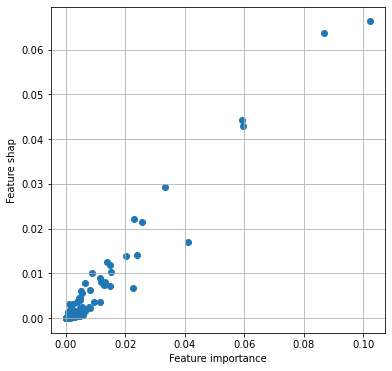

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(importances['importance'], shap_values_mean['mean_abs_shap'])
ax.grid()
ax.set_xlabel('Feature importance')
ax.set_ylabel('Feature shap')
plt.show()

### Plot most influential features

This is a plot of the mean absolute Shap values.

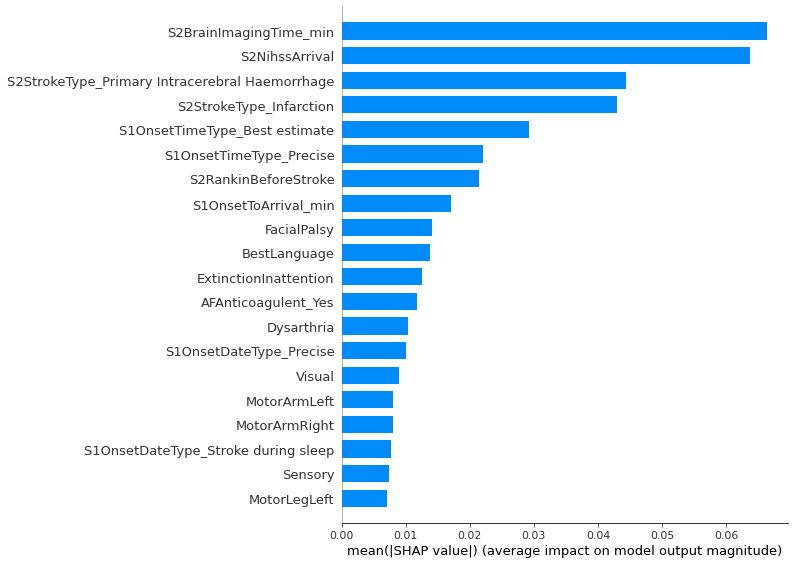

In [10]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

### Beeswarm plot

A Beeswarm plot shows all points. The feature value for each point is shown by the colour, and its position indicates the Shap value for that instance.

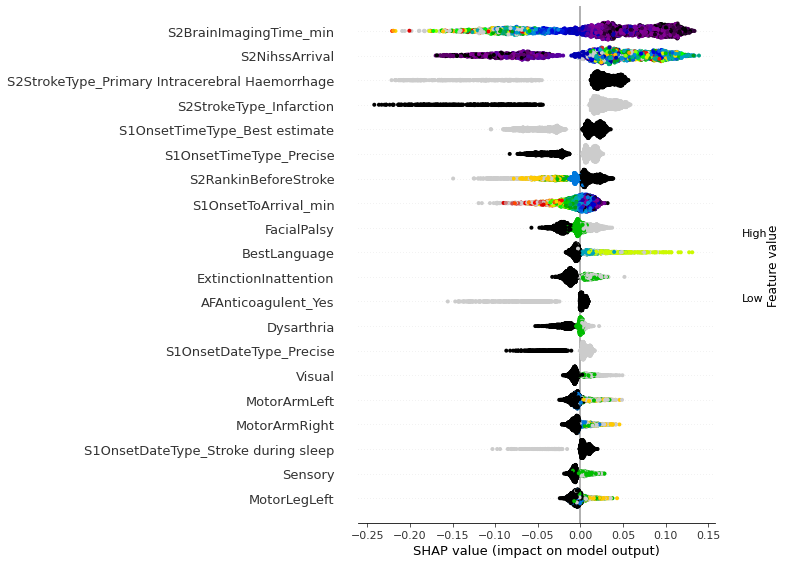

In [11]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features, 
                  cmap=plt.get_cmap('nipy_spectral'),show=False)

plt.show()

### Plot Waterfall and decision plot plots for instances with low or high probability of receiving thrombolysis

Waterfall plot and decision plots are alternative ways of plotting the influence of features for individual cases.

In [12]:
# Get the location of an example each where probability of giving thrombolysis
# is <0.1 or >0.9

location_low_probability = np.where(y_prob < 0.1)[0][0]
location_high_probability = np.where(y_prob > 0.9)[0][0]

An example with low probability of receiving thrombolysis.

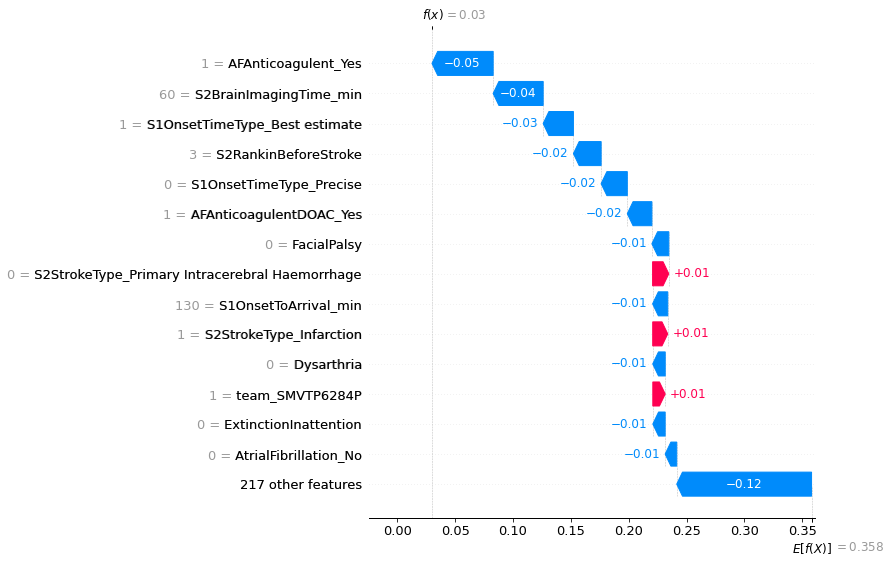

In [13]:
shap.plots.waterfall(shap_values_extended[location_low_probability][:,1], 
                     max_display=15)

The base value is 0.36


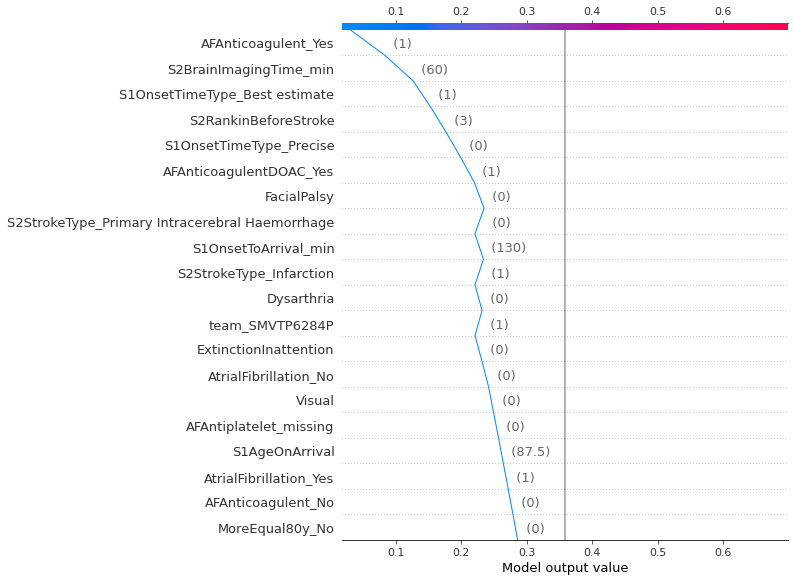

In [14]:
instance = location_low_probability

chosen_instance = X_test.iloc[instance]
shap_values_instance = shap_values[instance]
expected_value = shap_values_extended.base_values[0][1]#explainer.expected_value
print(f"The base value is {expected_value:0.2f}")

shap.decision_plot(expected_value, shap_values_instance, chosen_instance)

An example with high probability of receiving thrombolysis.

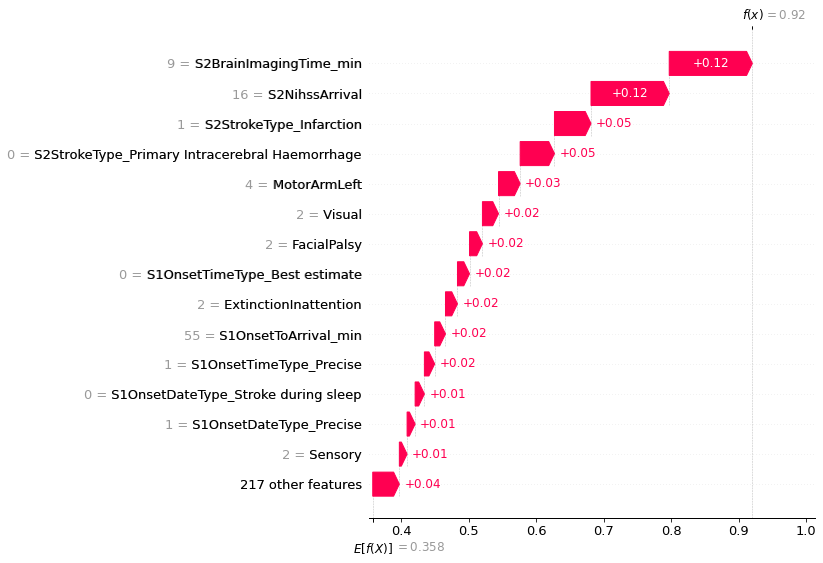

In [15]:
shap.plots.waterfall(shap_values_extended[location_high_probability][:,1], 
                     max_display=15)

The base value is 0.36


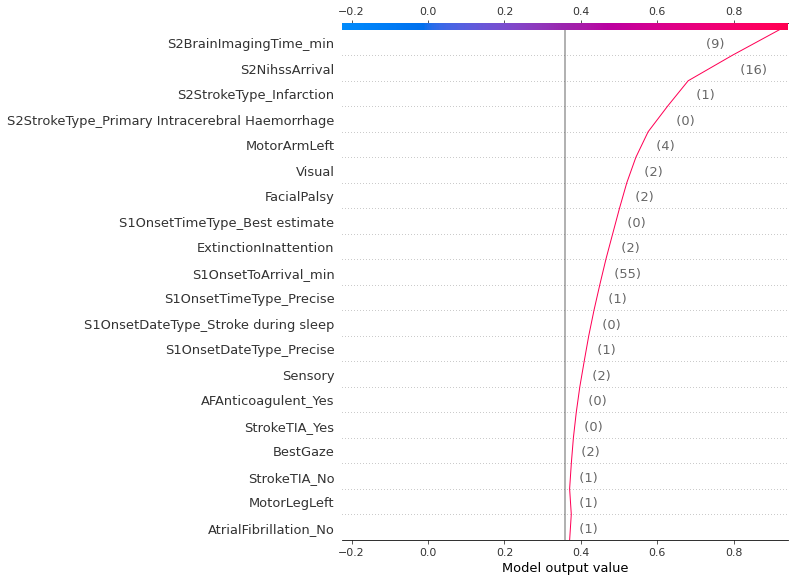

In [16]:
instance = location_high_probability

chosen_instance = X_test.iloc[instance]
shap_values_instance = shap_values[instance]
expected_value = shap_values_extended.base_values[0][1]#explainer.expected_value
print(f"The base value is {expected_value:0.2f}")

shap.decision_plot(expected_value, shap_values_instance, chosen_instance)

### Show the relationship between feature value and Shap value for top 5 influential features.

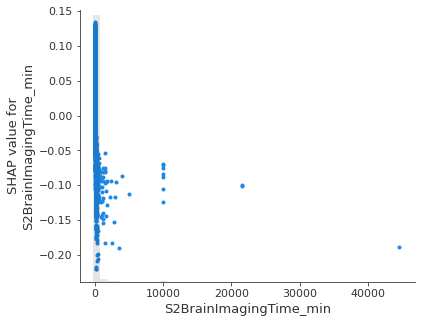

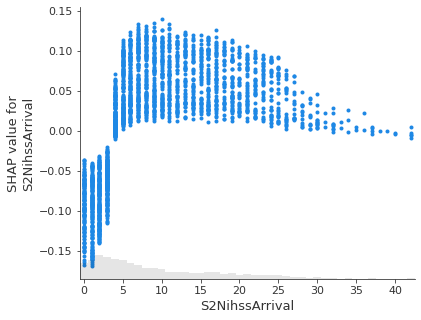

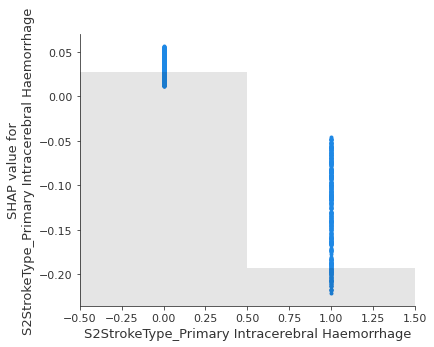

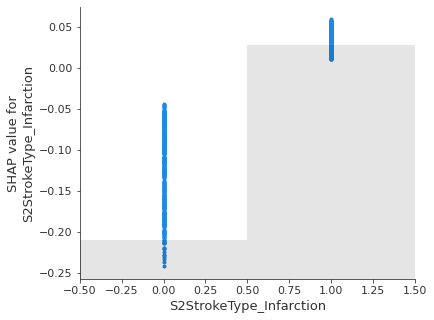

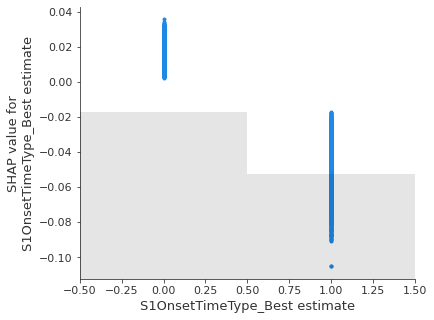

In [17]:
feat_to_show = top_10_shap.index[0:5]

for feat in feat_to_show:
    shap.plots.scatter(shap_values_extended[:, feat][:,1], x_jitter=0)

Examine `S2BrainImagingTime_min` in range 0-400 minutes.

(0.0, 400.0)

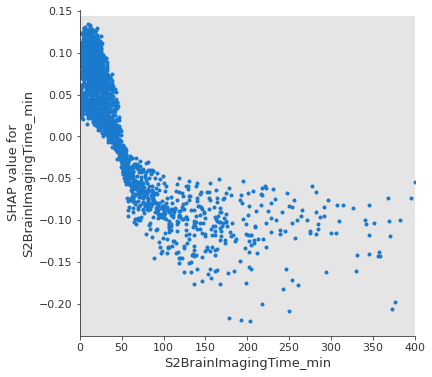

In [18]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
shap.plots.scatter(shap_values_extended[:, 'S2BrainImagingTime_min'][:,1], 
                   x_jitter=0, ax=ax, show=False)
ax.set_xlim(0,400)